## Demographics table

In [73]:
import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import librosa

from data_analysis.dataloader.dataloader import DataLoader
from util.helpers import prepare_demographics

from config.config import Config
from config.constants import Constants

In [74]:

def load_data(task):
    transcript_version = 'google'
    config = Config.from_dict({'config_linguistic_features': {'feature_groups': ['literature_features']},#, 'LIWC_features']}, 
                               'config_data': {'transcript_version': transcript_version, 'task': task, 'split': 'full'},
                               'config_model': {'cv_splits': 1}})
    dataloader = DataLoader(config=config)
    dataset = dataloader.load_data()

    return dataset

dataset = load_data('pictureDescription')

Initializing dataloader LUHA dataloader (transcript_version google, task pictureDescription) Split full
Loading data using dataloader LUHA dataloader
Using theory factor scores version 2025-01-07-1929
Standardizing theory factor scores to zero mean and unit variance. This makes comparison of certain evaluation metrics, beta coefficients etc. more interpretable.
Combining cookieTheft and picnicScene to get pictureDescription... ... done.
Loading train/test set from /Users/jheitz/git/luha-prolific-study/src/resources/train_test_split_2025-01-08_17-03.csv


In [75]:
dataset.data_split

array(['', '', '', ..., 'train', 'test', 'train'], dtype=object)

In [76]:
demographics = dataset.demographics
demographics['data_split'] = dataset.data_split
demographics['transcript_length'] = pd.Series(dataset.transcripts).apply(lambda x: len(re.split("\s+", x)) if not pd.isna(x) else None)
demographics['mean_cognition'] = dataset.mean_composite_cognitive_score
for composite_score in dataset.factor_scores_theory.columns:
    demographics[composite_score] = dataset.factor_scores_theory[composite_score]
demographics

,sex_prolific,ethnicity,country_of_birth,country_of_residence,nationality,age_prolific,age,gender,education,language,...,consent_data_further_use,gender_unified,education_binary,data_split,transcript_length,mean_cognition,composite_memory,composite_language,composite_speed,composite_executive_function
0,Female,White,Malta,United Kingdom,United Kingdom,61,61.0,f,bachelor,english_british,...,No,f,high-education,,289.0,NaN,NaN,NaN,NaN,NaN
1,Female,White,United Kingdom,United Kingdom,United Kingdom,63,63.0,f,master,english_british,...,Yes,f,high-education,,457.0,NaN,NaN,NaN,NaN,NaN
2,Male,White,United Kingdom,United Kingdom,United Kingdom,64,64.0,m,bachelor,english_british,...,Yes Except Recordings,m,high-education,,361.0,NaN,NaN,NaN,NaN,NaN
3,Male,White,United Kingdom,United Kingdom,United Kingdom,62,62.0,m,high_school,english_british,...,Yes,m,low-education,,265.0,NaN,NaN,NaN,NaN,NaN
4,Male,White,United Kingdom,United Kingdom,United Kingdom,73,73.0,m,bachelor,english_british,...,Yes,m,high-education,,280.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,Male,White,United States,United States,United States,74,74.0,m,vocational,english_american,...,Yes,m,low-education,test,304.0,-1.387163,-1.978423,-1.129010,-1.678355,-0.762865
999,Female,Mixed,United States,United States,United States,60,60.0,f,high_school,english_american,...,Yes,f,low-education,test,171.0,0.007481,-0.784269,0.236125,0.116117,0.461949
1000,Female,White,United States,United States,United States,70,70.0,f,bachelor,english_american,...,Yes,f,high-education,train,268.0,-0.093217,0.675272,-0.579871,-0.393217,-0.075053
1001,Male,White,United States,United States,United States,71,72.0,m,master,english_american,...,Yes,m,high-education,test,191.0,-2.163991,-1.058312,-2.112216,-3.299513,-2.185922


In [77]:
demographics['audio_length'] = pd.Series(dataset.audio_files).apply(lambda path: librosa.get_duration(path=path) if not pd.isna(path) else None)


def clean_audio_length(length):
    if length > 900:  # 15min
        print(f"Outlier length: {length}. Removing...")
        return None
    else:
        return length
demographics['audio_length'] = demographics['audio_length'].apply(clean_audio_length)


Outlier length: 4991.919916666667. Removing...


In [78]:
demographics_prepared = prepare_demographics(dataset.demographics)
demographics_prepared

(       age  gender_unified  education_binary  country
 0     61.0               0               1.0      0.0
 1     63.0               0               1.0      0.0
 2     64.0               1               1.0      0.0
 3     62.0               1               0.0      0.0
 4     73.0               1               1.0      0.0
 ...    ...             ...               ...      ...
 998   74.0               1               0.0      1.0
 999   60.0               0               0.0      1.0
 1000  70.0               0               1.0      1.0
 1001  72.0               1               1.0      1.0
 1002  64.0               1               1.0      1.0
 
 [1003 rows x 4 columns],
 {'gender_unified': {'f': 0, 'm': 1},
  'education_binary': {'low-education': 0, 'high-education': 1},
  'country': {'uk': 0, 'usa': 1}})

In [79]:
demographics_train = demographics.query("data_split == 'train'")
demographics_test = demographics.query("data_split == 'test'")
demographics_subsets = {'train': demographics_train, 'test': demographics_test, 'full': demographics}

demographic_statistics_text = defaultdict(dict)
demographic_statistics = defaultdict(dict)

def statistics_categorical(col):
     for split, subset in demographics_subsets.items():
        value_counts = subset[col].value_counts()
        values_counts_with_percentage = {val: f"{count} ({count/subset[col].shape[0]*100:.1f}%)" for val, count in value_counts.items()}
        
        if col == 'education':
            value_counts_here = subset['education_binary'].value_counts()
            values_counts_with_percentage_addition = {f"(Summary) {val}": f"{count} ({count/subset[col].shape[0]*100:.1f}%)" for val, count in value_counts_here.items()}
            values_counts_with_percentage = {**values_counts_with_percentage, **values_counts_with_percentage_addition}
        
        demographic_statistics_text[col][split] = values_counts_with_percentage
        demographic_statistics[col][split] = value_counts
         
         
def statistics_continuous(col):
    for split, subset in demographics_subsets.items():
        mean, std = np.mean(subset[col]), np.std(subset[col])
        mean_std_str = f"{mean:.2f} +- {std:.2f}"
        
        demographic_statistics_text[col][split] = mean_std_str
        demographic_statistics[col][split] = subset[col]

         


for col in ['age']:
    statistics_continuous(col)

for col in ['gender_unified', 'country', 'language', 'education', 'ethnicity', ]:
   statistics_categorical(col) 

for col in ['socioeconomic', 'transcript_length', 'audio_length', 'mean_cognition', 'composite_language', 'composite_executive_function', 'composite_memory', 'composite_speed']:
    statistics_continuous(col)
    
    



In [80]:
demographic_statistics['education']

{'train': education
 bachelor                297
 high_school             209
 master                  127
 vocational               89
 phd                      48
 less_than_highschool     18
 Name: count, dtype: int64,
 'test': education
 bachelor                85
 high_school             45
 master                  30
 vocational              26
 less_than_highschool     6
 phd                      5
 Name: count, dtype: int64,
 'full': education
 bachelor                389
 high_school             257
 master                  158
 vocational              117
 phd                      54
 less_than_highschool     24
 no_answer                 4
 Name: count, dtype: int64}

In [81]:
#from scipy.stats import fisher_exact
from util.scipy_fisher_exact import fisher_exact
from scipy.stats import ttest_ind, chi2_contingency

table_rows = []

first_row = {'group': 'total', 'train': demographics_subsets['train'].shape[0], 'test': demographics_subsets['test'].shape[0]}
table_rows.append(first_row)
for col in demographic_statistics_text.keys():
    if isinstance(demographic_statistics_text[col]['train'], dict):
        values = list(demographic_statistics[col]['train'].keys())
        values += [c for c in demographic_statistics[col]['test'].keys() if c not in values]
        contingency_table = pd.DataFrame([
            {val: demographic_statistics[col]['train'].get(val, 0) for val in values},
            {val: demographic_statistics[col]['test'].get(val, 0) for val in values},
        ])
        fisher_exact_pval = fisher_exact(contingency_table.T).pvalue
        expected_frequencies = contingency_table.iloc[1,:] / np.sum(contingency_table.iloc[1,:]) * np.sum(contingency_table.iloc[0,:])
        #display(contingency_table)
        chisquare_pval = chi2_contingency(contingency_table).pvalue
        values_text = list(demographic_statistics_text[col]['train'].keys())
        values_text += [c for c in demographic_statistics_text[col]['test'].keys() if c not in values_text]
        for i, val in enumerate(values_text):
            if i == 0:
                table_rows.append({'group': col, 'train': '', 'test': '', 'pval': f"{fisher_exact_pval:.2f}"})  #  / {chisquare_pval}
            row = {'group': f"\\quad {val}", 'train': demographic_statistics_text[col]['train'].get(val, f"0 (0%)"), 'test': demographic_statistics_text[col]['test'].get(val, f"0 (0%)"), 'pval': ''}
            table_rows.append(row)
            
    else: 
        ttest = ttest_ind(demographic_statistics[col]['train'], demographic_statistics[col]['test'], nan_policy='omit')
        #print(f"   col: {list(demographic_statistics[col]['train'])}", "|", list(demographic_statistics[col]['test']), ttest.pvalue)
        row = {'group': col, 'train': demographic_statistics_text[col]['train'], 'test': demographic_statistics_text[col]['test'], "pval": f"{ttest.pvalue:.3f}"}
        table_rows.append(row)

In [82]:
table_df = pd.DataFrame(table_rows)
table_df = table_df.rename(columns={'train': 'Development set', 'test': 'Holdout test set'})
table_df

,group,Development set,Holdout test set,pval
0,total,788,197,NaN
1,age,65.50 +- 4.82,65.42 +- 4.77,0.832
2,gender_unified,,,0.57
3,\quad f,487 (61.8%),117 (59.4%),
4,\quad m,301 (38.2%),80 (40.6%),
5,country,,,0.69
6,\quad uk,394 (50.0%),95 (48.2%),
7,\quad usa,394 (50.0%),102 (51.8%),
8,language,,,0.20
9,\quad english_british,390 (49.5%),95 (48.2%),


In [83]:
print(table_df.to_latex(index=False).replace("%", "\%").replace("_", "-"))

\begin{tabular}{llll}
\toprule
group & Development set & Holdout test set & pval \\
\midrule
total & 788 & 197 & NaN \\
age & 65.50 +- 4.82 & 65.42 +- 4.77 & 0.832 \\
gender-unified &  &  & 0.57 \\
\quad f & 487 (61.8\%) & 117 (59.4\%) &  \\
\quad m & 301 (38.2\%) & 80 (40.6\%) &  \\
country &  &  & 0.69 \\
\quad uk & 394 (50.0\%) & 95 (48.2\%) &  \\
\quad usa & 394 (50.0\%) & 102 (51.8\%) &  \\
language &  &  & 0.20 \\
\quad english-british & 390 (49.5\%) & 95 (48.2\%) &  \\
\quad english-american & 386 (49.0\%) & 102 (51.8\%) &  \\
\quad english-other & 12 (1.5\%) & 0 (0\%) &  \\
education &  &  & 0.22 \\
\quad bachelor & 297 (37.7\%) & 85 (43.1\%) &  \\
\quad high-school & 209 (26.5\%) & 45 (22.8\%) &  \\
\quad master & 127 (16.1\%) & 30 (15.2\%) &  \\
\quad vocational & 89 (11.3\%) & 26 (13.2\%) &  \\
\quad phd & 48 (6.1\%) & 5 (2.5\%) &  \\
\quad less-than-highschool & 18 (2.3\%) & 6 (3.0\%) &  \\
\quad (Summary) high-education & 472 (59.9\%) & 120 (60.9\%) &  \\
\quad (Summary) l

In [84]:
# full dataset
table_rows = []
first_row = {'group': 'total', 'full': demographics_subsets['full'].shape[0]}
table_rows.append(first_row)
for col in demographic_statistics_text.keys():
    if isinstance(demographic_statistics_text[col]['full'], dict):
        values = list(demographic_statistics[col]['full'].keys())
        contingency_table = pd.DataFrame([
            {val: demographic_statistics[col]['full'].get(val, 0) for val in values},
        ])
        values_text = list(demographic_statistics_text[col]['full'].keys())
        for i, val in enumerate(values_text):
            if i == 0:
                table_rows.append({'group': col, 'full': ''})  
            row = {'group': f"\\quad {val}", 'full': demographic_statistics_text[col]['full'].get(val, f"0 (0%)")}
            table_rows.append(row)

    else:
        row = {'group': col, 'full': demographic_statistics_text[col]['full']}
        table_rows.append(row)

table_df = pd.DataFrame(table_rows)
table_df = table_df.rename(columns={'train': 'Development set', 'test': 'Holdout test set'})
table_df


,group,full
0,total,1003
1,age,65.46 +- 4.81
2,gender_unified,
3,\quad f,615 (61.3%)
4,\quad m,388 (38.7%)
5,country,
6,\quad uk,501 (50.0%)
7,\quad usa,501 (50.0%)
8,\quad no_answer,1 (0.1%)
9,language,


In [85]:
print(table_df.to_latex(index=False).replace("%", "\%").replace("_", "-"))


\begin{tabular}{ll}
\toprule
group & full \\
\midrule
total & 1003 \\
age & 65.46 +- 4.81 \\
gender-unified &  \\
\quad f & 615 (61.3\%) \\
\quad m & 388 (38.7\%) \\
country &  \\
\quad uk & 501 (50.0\%) \\
\quad usa & 501 (50.0\%) \\
\quad no-answer & 1 (0.1\%) \\
language &  \\
\quad english-british & 498 (49.7\%) \\
\quad english-american & 492 (49.1\%) \\
\quad english-other & 13 (1.3\%) \\
education &  \\
\quad bachelor & 389 (38.8\%) \\
\quad high-school & 257 (25.6\%) \\
\quad master & 158 (15.8\%) \\
\quad vocational & 117 (11.7\%) \\
\quad phd & 54 (5.4\%) \\
\quad less-than-highschool & 24 (2.4\%) \\
\quad no-answer & 4 (0.4\%) \\
\quad (Summary) high-education & 601 (59.9\%) \\
\quad (Summary) low-education & 398 (39.7\%) \\
\quad (Summary) no-answer & 4 (0.4\%) \\
ethnicity &  \\
\quad White & 916 (91.3\%) \\
\quad Black & 49 (4.9\%) \\
\quad Mixed & 19 (1.9\%) \\
\quad Asian & 8 (0.8\%) \\
\quad Other & 8 (0.8\%) \\
\quad DATA-EXPIRED & 3 (0.3\%) \\
socioeconomic & 5.58 +-

gender_unified []
country ['no_answer']
language []


/var/folders/r9/m9sbl76n2l35rg8_r625jr1m0000gn/T/ipykernel_34714/2428340990.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data_here.index, rotation=45, ha='right')
/var/folders/r9/m9sbl76n2l35rg8_r625jr1m0000gn/T/ipykernel_34714/2428340990.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data_here.index, rotation=45, ha='right')
/var/folders/r9/m9sbl76n2l35rg8_r625jr1m0000gn/T/ipykernel_34714/2428340990.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data_here.index, rotation=45, ha='right')


education []
ethnicity ['DATA_EXPIRED']


/var/folders/r9/m9sbl76n2l35rg8_r625jr1m0000gn/T/ipykernel_34714/2428340990.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data_here.index, rotation=45, ha='right')
/var/folders/r9/m9sbl76n2l35rg8_r625jr1m0000gn/T/ipykernel_34714/2428340990.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data_here.index, rotation=45, ha='right')


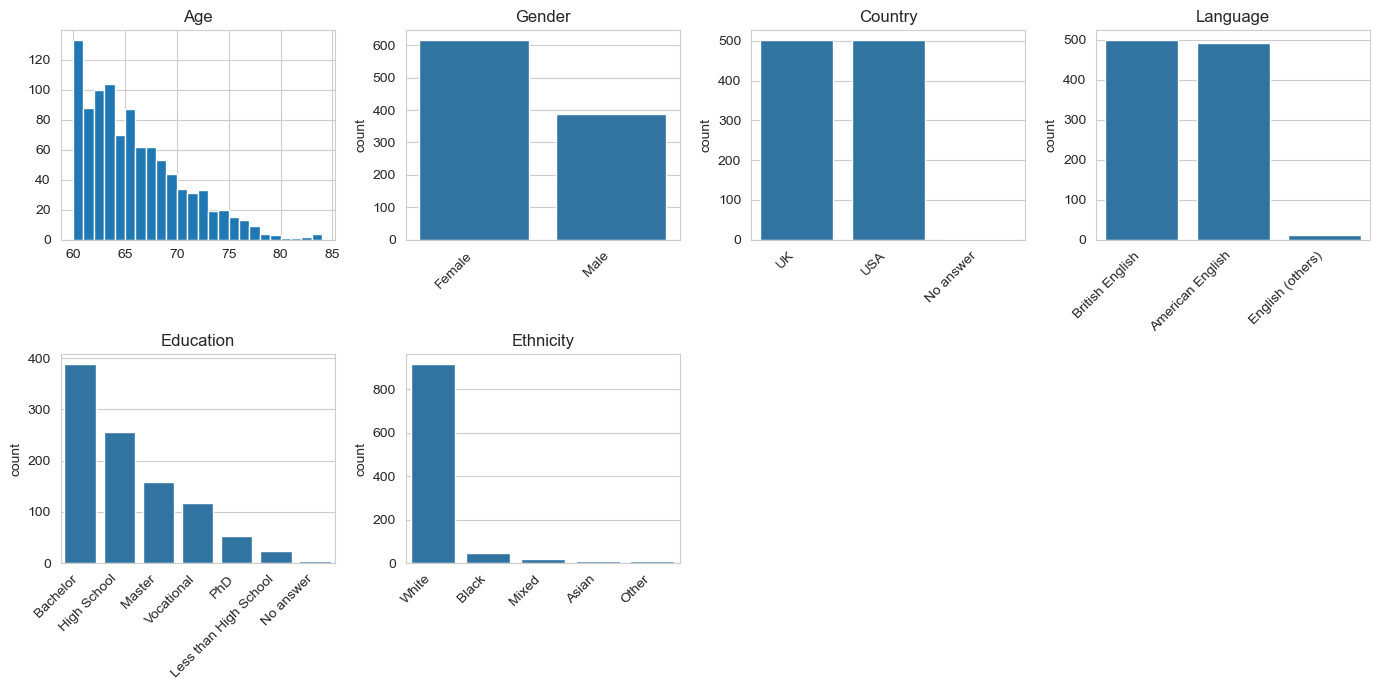

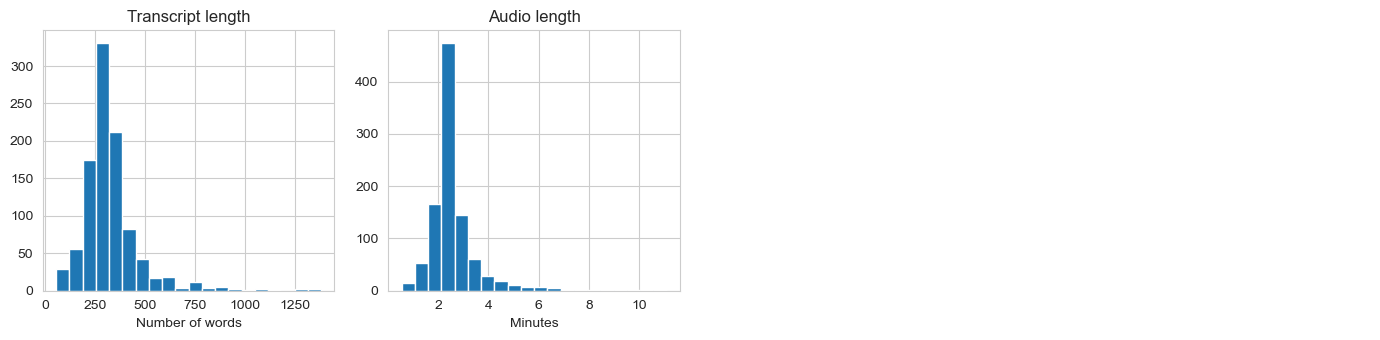

In [93]:

translate_dict = {
    'f': 'Female',
    'm': 'Male',
    'uk': 'UK',
    'usa': 'USA',
    'english_british': 'British English',
    'english_american': 'American English',
    'english_other': 'English (others)',
    'bachelor': 'Bachelor',
    'high_school': 'High School',
    'master': 'Master',
    'phd': 'PhD',
    'no_answer': 'No answer',
    'vocational': 'Vocational',
    'less_than_highschool': 'Less than High School',
    'age': 'Age',
    'socioeconomic': 'Socioeconomic status',
    'education': 'Education',
    'country': 'Country',
    'language': 'Language',
    'ethnicity': 'Ethnicity',
    'gender_unified': 'Gender',
    'transcript_length': 'Transcript length',
    'audio_length': 'Audio length',
    
}

value_removal = defaultdict(list, {
    'country': ['no_answer'],
    'ethnicity': ['DATA_EXPIRED']
})

import seaborn as sns

def create_table(cols, postfix=""):
    nrows = int(np.ceil(len(cols) / 4))
    ncols = 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3.5, nrows*3.5))
    axes = axes.flatten()

    for col, ax in zip(cols, axes):
        if isinstance(demographic_statistics_text[col]['full'], dict):
            data_here = demographic_statistics[col]['full'].rename(translate_dict)
            print(col, value_removal[col])
            data_here = data_here[~data_here.index.isin(value_removal[col])]
            sns.barplot(data_here, ax=ax)
            ax.set_xticklabels(data_here.index, rotation=45, ha='right')
            ax.set_xlabel("")
    
        else:
            bins = 20
            if col == 'age':
                bins = np.arange(60, 85, 1)
            elif col == 'socioeconomic':
                bins = np.arange(0, 10, 1)
                
            data_here = demographic_statistics[col]['full'].copy()
            unit = ""
            if col == 'transcript_length':
                data_here = data_here[data_here < 5000]
                unit = "Number of words"
            elif col == 'audio_length':
                data_here = data_here / 60
                unit = "Minutes"
            ax.hist(data_here, bins=bins)
            ax.set_xlabel(unit)
        
        ax.set_title(translate_dict.get(col, col))
        
        plt.tight_layout()
    
    for ax in axes[len(cols):]:
        ax.axis('off')
    
    plt.savefig(f"plots/demographics{postfix}.png", transparent=True)
    plt.show()
    

create_table(['age', 'gender_unified', 'country', 'language', 'education', 'ethnicity'])
create_table(['transcript_length', 'audio_length'], postfix="_speech")
#create_table(['mean_cognition', 'composite_language', 'composite_executive_function', 'composite_memory', 'composite_speed'], postfix="_continuous")




        


In [41]:
value_removal['gender']

[]

In [87]:
demographic_statistics_text['age']

{'train': '65.50 +- 4.82', 'test': '65.42 +- 4.77', 'full': '65.46 +- 4.81'}